## Notebook to use VQGAN

based on https://colab.research.google.com/github/CompVis/taming-transformers/blob/master/scripts/reconstruction_usage.ipynb#scrollTo=S4G0FaWPx2bE

Check if is possible to use celebA pretrained.
Otherwise I could train by myself using the celebA dataset.

Include the DALL-E predictions!


In [2]:
# download a VQGAN with f=16 (16x compression per spatial dimension) and with a codebook with 1024 entries
!mkdir -p logs/vqgan_imagenet_f16_1024/checkpoints
!mkdir -p logs/vqgan_imagenet_f16_1024/configs
!wget 'https://heibox.uni-heidelberg.de/f/140747ba53464f49b476/?dl=1' -O 'logs/vqgan_imagenet_f16_1024/checkpoints/last.ckpt' 
!wget 'https://heibox.uni-heidelberg.de/f/6ecf2af6c658432c8298/?dl=1' -O 'logs/vqgan_imagenet_f16_1024/configs/model.yaml' 

--2021-12-26 13:15:26--  https://heibox.uni-heidelberg.de/f/140747ba53464f49b476/?dl=1
Resolving heibox.uni-heidelberg.de (heibox.uni-heidelberg.de)... 129.206.7.113
Connecting to heibox.uni-heidelberg.de (heibox.uni-heidelberg.de)|129.206.7.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://heibox.uni-heidelberg.de/seafhttp/files/7ae79321-beb3-4a7d-b4f1-22e675e73e4a/last.ckpt [following]
--2021-12-26 13:15:26--  https://heibox.uni-heidelberg.de/seafhttp/files/7ae79321-beb3-4a7d-b4f1-22e675e73e4a/last.ckpt
Reusing existing connection to heibox.uni-heidelberg.de:443.
HTTP request sent, awaiting response... 200 OK
Length: 957954257 (914M) [application/octet-stream]
Saving to: ‘logs/vqgan_imagenet_f16_1024/checkpoints/last.ckpt’

logs/vqgan_imagenet 100%[===================>] 913.58M  14.9MB/s    in 61s     

2021-12-26 13:16:27 (15.1 MB/s) - ‘logs/vqgan_imagenet_f16_1024/checkpoints/last.ckpt’ saved [957954257/957954257]

--2021-12-26 13:16:31--  h

In [1]:
%%capture
!pip install omegaconf>=2.0.0 pytorch-lightning>=1.0.8 einops>=0.3.0
import sys
sys.path.append(".")

# also disable grad to save memory
import torch
from torchvision import datasets, transforms
from imutils import paths
import PIL
from PIL import Image
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import numpy as np
torch.set_grad_enabled(False)

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
import yaml
import torch
from omegaconf import OmegaConf
from taming.models.vqgan import VQModel, GumbelVQ

def load_config(config_path, display=False):
    config = OmegaConf.load(config_path)
    if display:
        print(yaml.dump(OmegaConf.to_container(config)))
    return config

def load_vqgan(config, ckpt_path=None, is_gumbel=False):
    if is_gumbel:
        model = GumbelVQ(**config.model.params)
    else:
        model = VQModel(**config.model.params)
    if ckpt_path is not None:
        sd = torch.load(ckpt_path, map_location="cpu")["state_dict"]
        missing, unexpected = model.load_state_dict(sd, strict=False)
    return model.eval()

def preprocess_vqgan(x):
    x = 2.*x - 1.
    return x

def custom_to_pil(x):
    x = x.detach().cpu()
    x = torch.clamp(x, -1., 1.)
    x = (x + 1.)/2.
    x = x.permute(1,2,0).numpy()
    x = (255*x).astype(np.uint8)
    x = Image.fromarray(x)
    if not x.mode == "RGB":
        x = x.convert("RGB")
    return x

def reconstruct_with_vqgan(x, model):
    # could also use model(x) for reconstruction but use explicit encoding and decoding here
    z, _, [_, _, indices] = model.encode(x)
    print(f"VQGAN --- {model.__class__.__name__}: latent shape: {z.shape[2:]}")
    xrec = model.decode(z)
    return xrec

def preprocess(img, target_image_size=256, map_dalle=True):
    s = min(img.size)
    
    #if s < target_image_size:
    #    raise ValueError(f'min dim for image {s} < {target_image_size}')
        
    r = target_image_size / s
    s = (round(r * img.size[1]), round(r * img.size[0]))
    img = TF.resize(img, s, interpolation=PIL.Image.LANCZOS)
    img = TF.center_crop(img, output_size=2 * [target_image_size])
    img = torch.unsqueeze(T.ToTensor()(img), 0)
    if map_dalle: 
        img = map_pixels(img)
    return img

In [14]:
config1024 = load_config("logs/vqgan_imagenet_f16_1024/configs/model.yaml", display=True)
model1024 = load_vqgan(config1024, ckpt_path="logs/vqgan_imagenet_f16_1024/checkpoints/last.ckpt").to(DEVICE)




model:
  base_learning_rate: 4.5e-06
  params:
    ddconfig:
      attn_resolutions:
      - 16
      ch: 128
      ch_mult:
      - 1
      - 1
      - 2
      - 2
      - 4
      double_z: false
      dropout: 0.0
      in_channels: 3
      num_res_blocks: 2
      out_ch: 3
      resolution: 256
      z_channels: 256
    embed_dim: 256
    lossconfig:
      params:
        codebook_weight: 1.0
        disc_conditional: false
        disc_in_channels: 3
        disc_start: 0
        disc_weight: 0.8
      target: taming.modules.losses.vqperceptual.VQLPIPSWithDiscriminator
    n_embed: 1024
  target: taming.models.vqgan.VQModel

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


## Load Image

In [15]:
images_dir=r"/home/matteo/NeuroGEN/Dataset/Img/img_align_celeba"
imagePaths = list(paths.list_images(images_dir))


x=PIL.Image.open(imagePaths[0])

In [20]:
x_vqgan = preprocess(x, target_image_size=320, map_dalle=False)

In [24]:
x_vqgan.max()

tensor(0.9882)

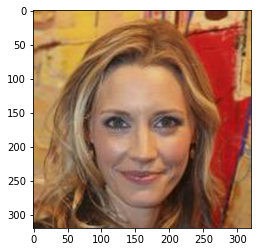

In [17]:
import matplotlib.pyplot as plt
plt.imshow(x_vqgan.squeeze().permute(1,2,0).numpy())

In [18]:
x_vqgan = x_vqgan.to(DEVICE)
x2 = reconstruct_with_vqgan(preprocess_vqgan(x_vqgan), model1024)

VQGAN --- VQModel: latent shape: torch.Size([20, 20])


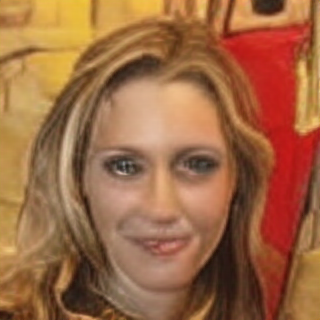

In [19]:
custom_to_pil(x2.squeeze())

In [36]:
print(x2.shape)

torch.Size([1, 3, 320, 320])
